<a href="https://colab.research.google.com/github/SaranyaKrishnasami/PySparkMLib_Project/blob/main/Regression%20Models/MLLib_PySpark_ECommerceCustomerSpendPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Reference :** spark.apache.org

**Release :** https://spark.apache.org/docs/latest/ml-guide.html

Spark MLLib

In [5]:
!pip install pyspark

In [6]:
from pyspark.sql import SparkSession # SQL
from pyspark.ml.regression import LinearRegression # ML Library
from pyspark.ml.feature import VectorAssembler

In [7]:
spark = SparkSession.builder.appName('mllibExercise').getOrCreate()


In [8]:
# the data format is in libsbm format
data = spark.read.csv('/content/sample_data/Ecommerce-Customers.csv' , inferSchema=True, header=True)

In [9]:
data.head(1)

[Row(Email='mstephenson@fernandez.com', Address='835 Frank TunnelWrightmouth, MI 82180-9605', Avatar='Violet', Avg Session Length=34.49726772511229, Time on App=12.65565114916675, Time on Website=39.57766801952616, Length of Membership=4.0826206329529615, Yearly Amount Spent=587.9510539684005)]

In [10]:
data.show(10)

+--------------------+--------------------+----------------+------------------+------------------+------------------+--------------------+-------------------+
|               Email|             Address|          Avatar|Avg Session Length|       Time on App|   Time on Website|Length of Membership|Yearly Amount Spent|
+--------------------+--------------------+----------------+------------------+------------------+------------------+--------------------+-------------------+
|mstephenson@ferna...|835 Frank TunnelW...|          Violet| 34.49726772511229| 12.65565114916675| 39.57766801952616|  4.0826206329529615|  587.9510539684005|
|   hduke@hotmail.com|4547 Archer Commo...|       DarkGreen| 31.92627202636016|11.109460728682564|37.268958868297744|    2.66403418213262|  392.2049334443264|
|    pallen@yahoo.com|24645 Valerie Uni...|          Bisque|33.000914755642675|11.330278057777512|37.110597442120856|   4.104543202376424| 487.54750486747207|
|riverarebecca@gma...|1414 David Throug...|   

# Data analysis
### The labels are the dependant variable / target to be detected
### Features are the inputs / independant variables for model training

Independant variable / Label to be predicted is: Yearlt amount Spent

Predictor Variables:
Email, Address , Time spent on App, session


In [11]:
data.printSchema()

root
 |-- Email: string (nullable = true)
 |-- Address: string (nullable = true)
 |-- Avatar: string (nullable = true)
 |-- Avg Session Length: double (nullable = true)
 |-- Time on App: double (nullable = true)
 |-- Time on Website: double (nullable = true)
 |-- Length of Membership: double (nullable = true)
 |-- Yearly Amount Spent: double (nullable = true)



In [12]:
data.columns

['Email',
 'Address',
 'Avatar',
 'Avg Session Length',
 'Time on App',
 'Time on Website',
 'Length of Membership',
 'Yearly Amount Spent']

#Feature engineering

In [13]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.linalg import Vectors

In [14]:
# Convert group of features into single vector
vector_assembler = VectorAssembler(inputCols=['Avg Session Length',
 'Time on App',
 'Time on Website',
 'Length of Membership'], outputCol='features')

In [15]:
# This step is to combines the combined feature to the original dataset
collated_data = vector_assembler.transform(data)

In [16]:
collated_data.printSchema()

root
 |-- Email: string (nullable = true)
 |-- Address: string (nullable = true)
 |-- Avatar: string (nullable = true)
 |-- Avg Session Length: double (nullable = true)
 |-- Time on App: double (nullable = true)
 |-- Time on Website: double (nullable = true)
 |-- Length of Membership: double (nullable = true)
 |-- Yearly Amount Spent: double (nullable = true)
 |-- features: vector (nullable = true)



# The model is going to be trained only on the feature vector obtained from

'Avg Session Length', 'Time on App', 'Time on Website'

In [17]:
finalDf = collated_data.select('features', 'Yearly Amount Spent')
finalDf.show()

+--------------------+-------------------+
|            features|Yearly Amount Spent|
+--------------------+-------------------+
|[34.4972677251122...|  587.9510539684005|
|[31.9262720263601...|  392.2049334443264|
|[33.0009147556426...| 487.54750486747207|
|[34.3055566297555...|  581.8523440352177|
|[33.3306725236463...|  599.4060920457634|
|[33.8710378793419...|   637.102447915074|
|[32.0215955013870...|  521.5721747578274|
|[32.7391429383803...|  549.9041461052942|
|[33.9877728956856...|  570.2004089636196|
|[31.9365486184489...|  427.1993848953282|
|[33.9925727749537...|  492.6060127179966|
|[33.8793608248049...|  522.3374046069357|
|[29.5324289670579...|  408.6403510726275|
|[33.1903340437226...|  573.4158673313865|
|[32.3879758531538...|  470.4527333009554|
|[30.7377203726281...|  461.7807421962299|
|[32.1253868972878...| 457.84769594494855|
|[32.3388993230671...| 407.70454754954415|
|[32.1878120459321...|  452.3156754800354|
|[32.6178560628234...|   605.061038804892|
+----------

In [18]:
train , test = finalDf.randomSplit([0.7,0.3])

In [19]:
train.describe().show()

+-------+-------------------+
|summary|Yearly Amount Spent|
+-------+-------------------+
|  count|                344|
|   mean|  497.9956987946292|
| stddev|  81.72085791852898|
|    min| 256.67058229005585|
|    max|  765.5184619388373|
+-------+-------------------+



In [20]:
test.describe().show()

+-------+-------------------+
|summary|Yearly Amount Spent|
+-------+-------------------+
|  count|                156|
|   mean|  502.2211457945061|
| stddev|  73.90288954910967|
|    min|  282.4712457199145|
|    max|  712.3963268096637|
+-------+-------------------+



In [21]:
lr = LinearRegression(featuresCol='features' , labelCol='Yearly Amount Spent',
                      predictionCol='prediction')

In [22]:
# Model training
lrModel = lr.fit(train)

In [23]:
test_result = lrModel.evaluate(test)

In [24]:
test_result.predictions['prediction']

Column<'prediction'>

In [25]:
test_result.residuals.show()

+-------------------+
|          residuals|
+-------------------+
|  6.950524590950408|
| -5.940180619784144|
|  9.451900076143033|
|  4.701223956252306|
| -22.94826575759714|
| -9.091920198679645|
|  2.969937287296375|
| 1.6150228037615193|
|-10.845090748306689|
| -7.479939283058684|
|-18.589184332757895|
|  16.95203006437464|
| 16.866119072155072|
|  5.860501921815228|
|-27.871255772039945|
| -9.788502137031742|
| -6.249672284003793|
| -13.31852261082281|
| -4.549706418113146|
|-3.6039781995688713|
+-------------------+
only showing top 20 rows



In [26]:
training_summary = lrModel.summary

In [27]:
training_summary.meanAbsoluteError

7.712601648285891

In [28]:
training_summary.rootMeanSquaredError

9.70410502394

In [29]:
training_summary.r2

0.9858580445706735

In [30]:
finalDf.show(10)

+--------------------+-------------------+
|            features|Yearly Amount Spent|
+--------------------+-------------------+
|[34.4972677251122...|  587.9510539684005|
|[31.9262720263601...|  392.2049334443264|
|[33.0009147556426...| 487.54750486747207|
|[34.3055566297555...|  581.8523440352177|
|[33.3306725236463...|  599.4060920457634|
|[33.8710378793419...|   637.102447915074|
|[32.0215955013870...|  521.5721747578274|
|[32.7391429383803...|  549.9041461052942|
|[33.9877728956856...|  570.2004089636196|
|[31.9365486184489...|  427.1993848953282|
+--------------------+-------------------+
only showing top 10 rows



In [31]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert to Pandas DataFrame
residuals_df = test_result.residuals
type(residuals_df)

pyspark.sql.dataframe.DataFrame

In [32]:
# Convert to Pandas DataFrame
residual_df = residuals_df.toPandas()
pandas_df = test_result.predictions.toPandas()

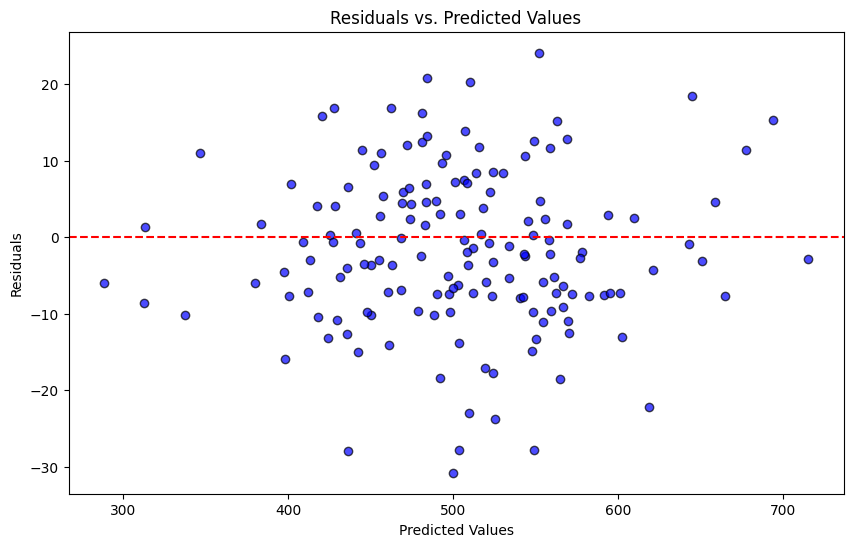

In [33]:
# Plot residuals vs. predicted values
plt.figure(figsize=(10, 6))
plt.scatter(pandas_df['prediction'], residual_df['residuals'], color="blue", edgecolor="k", alpha=0.7)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs. Predicted Values")
plt.show()


A Model performace is done by evaluating the model using the metrics for the task we do during the modeling.

`QUALITATIVE & QUANTITAIVE METRICS`

QUALITATIVE METRICS:

For regression the metric used are,
RMSE - The metric that is in the scale of the values showing the difference between the predicted and the actual values
R2 - Coefficient of Determination denotes the percentage to which the model can explain the variance of the data.
These two metrics are important for Model Validation

QUANTITAIVE METRICS:

Observing the predicted values, checking the correlation of the indepedant and dependant values.


In [38]:
from pyspark.sql.functions import corr
data.select(corr('Yearly Amount Spent', 'Length of Membership')).show()


+-----------------------------------------------+
|corr(Yearly Amount Spent, Length of Membership)|
+-----------------------------------------------+
|                             0.8090835682475807|
+-----------------------------------------------+



In [40]:
from pyspark.sql.functions import corr
data.select(corr('Yearly Amount Spent', 'Time on Website')).show()
data.select(corr('Yearly Amount Spent', 'Time on App')).show()
data.select(corr('Yearly Amount Spent', 'Avg Session Length')).show()



+------------------------------------------+
|corr(Yearly Amount Spent, Time on Website)|
+------------------------------------------+
|                      -0.00264084467215...|
+------------------------------------------+

+--------------------------------------+
|corr(Yearly Amount Spent, Time on App)|
+--------------------------------------+
|                   0.49932777005345047|
+--------------------------------------+

+---------------------------------------------+
|corr(Yearly Amount Spent, Avg Session Length)|
+---------------------------------------------+
|                          0.35508829470764314|
+---------------------------------------------+

